In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [2]:
German = pd.read_csv('GermanCredit.csv')
German.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,Good,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,Bad,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,Good,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,Good,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,Bad,...,0,0,1,0,0,1,0,0,1,0


In [3]:
# show non-numeric columns
German.select_dtypes(exclude=[np.number]).head()

# Map Class column to integer values
German['Class'] = German.Class.map({u'Good': 1, u'Bad': 0})

In [4]:
#Split German to X and y, train and target
y = German.Class
X = German.drop('Class', axis=1)

#Cut low var features, threshold can change
selector = VarianceThreshold(threshold= 0.05)
X_var_cut = selector.fit_transform(X)
X_var_cut.shape

(1000, 45)

In [5]:
from sklearn.preprocessing import scale
X_var_cut_scaled = scale(X_var_cut, axis=0, with_mean=True, with_std=True, copy=True)

/home/sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [6]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_var_cut_scaled, y, test_size=0.2, random_state=42)

In [ ]:
print(__doc__)

# Utility function to move the midpoint of a colormap to be around the values of interest
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# dataset for grid search
X = X_train
y = y_train

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
y_2d = y

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=42)
#Use three processors for the Grid Search
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, n_jobs = 3)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

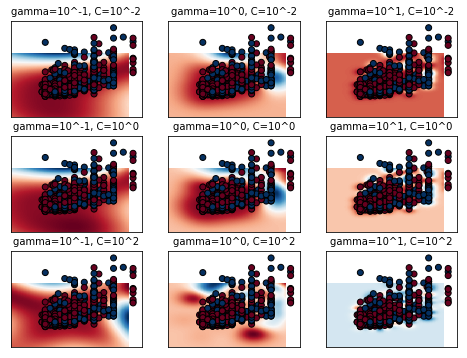

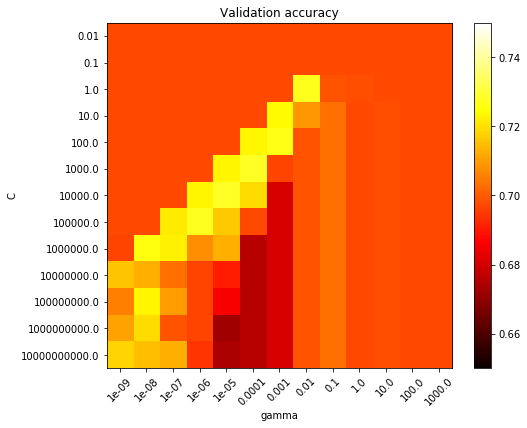

In [19]:
# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin= 0.65, vmax= 0.75, midpoint=0.7))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()